# Fine tuned Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

device = torch.device("cuda")

In [2]:
train_df = pd.read_csv('train.csv')
train_df = train_df.dropna()
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(2499, 5)
(500, 5)


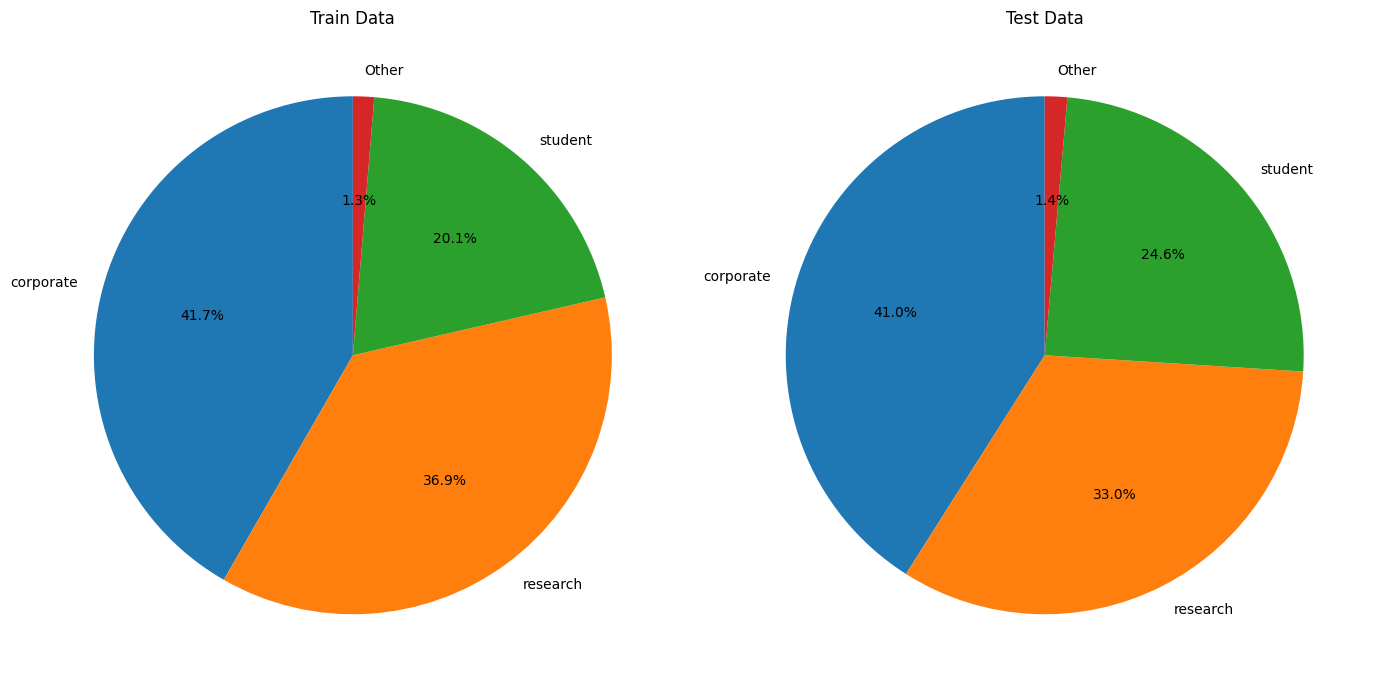

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

train_df['label'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Train Data')
axes[0].set_ylabel('')

test_df['label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Test Data')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [4]:
labels = train_df['label'].unique().tolist()
labels

['corporate', 'student', 'research', 'Other']

In [5]:
NUM_LABELS= len(labels)
id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}
label2id


{'corporate': 0, 'student': 1, 'research': 2, 'Other': 3}

In [6]:
train_df['labels'] = train_df['label'].map(label2id)
test_df['labels'] = test_df['label'].map(label2id)

In [7]:
train_df.drop(columns=['label','Unnamed: 0.1','Unnamed: 0'], inplace=True)
test_df.drop(columns=['label','Unnamed: 0.1','Unnamed: 0'], inplace=True)

In [8]:
train_df['labels'].value_counts(normalize = True)

,proportion
labels,
0,0.416967
2,0.368948
1,0.200880
3,0.013205


In [9]:
# Extract texts and labels from train_df and test_df
train_texts = train_df['body'].tolist()
train_labels = train_df['labels'].tolist()

test_texts = test_df['body'].tolist()
test_labels = test_df['labels'].tolist()


In [10]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.body = df['body']
        self.targets = df['labels'].values
        self.max_len = max_len

    def __len__(self):
        return len(self.body)

    def __getitem__(self, idx):
        body = str(self.df['body'].iloc[idx])
        body = " ".join(body.split())

        inputs = self.tokenizer.encode_plus(
            body,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )


        target = self.targets[idx]

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [13]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
# train_dataset[0]['attention_mask'].shape


In [14]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [15]:
# Check shapes for first batch

for batch in train_data_loader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention Masks shape:", batch['attention_mask'].shape)
    print("Token Type IDs shape:", batch['token_type_ids'].shape)
    print("Targets shape:", batch['targets'].shape)
    break

Input IDs shape: torch.Size([16, 512])
Attention Masks shape: torch.Size([16, 512])
Token Type IDs shape: torch.Size([16, 512])
Targets shape: torch.Size([16])


In [16]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=targets)

        # Get the loss
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_data_loader)
    print(f'Epoch: {epoch + 1}, Average Loss: {avg_loss:.4f}')

model.save_pretrained('./fine_tuned_bert')


Epoch: 1, Average Loss: 0.6553
Epoch: 2, Average Loss: 0.4146
Epoch: 3, Average Loss: 0.3627
Epoch: 4, Average Loss: 0.3113
Epoch: 5, Average Loss: 0.2708
Epoch: 6, Average Loss: 0.2341
Epoch: 7, Average Loss: 0.2014
Epoch: 8, Average Loss: 0.1812
Epoch: 9, Average Loss: 0.1587
Epoch: 10, Average Loss: 0.1554


In [20]:
!zip -r Fine_tuned.zip fine_tuned_bert

  adding: fine_tuned_bert/ (stored 0%)
  adding: fine_tuned_bert/model.safetensors (deflated 7%)
  adding: fine_tuned_bert/config.json (deflated 52%)


In [25]:
model = BertForSequenceClassification.from_pretrained('./fine_tuned_bert')
model.to(device)
model.eval()  # Set the model to evaluation mode

def predict(text,id2label):
    # Preprocess the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',  # Return PyTorch tensors
    )

    input_ids = encoding['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
    attention_mask = encoding['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
    token_type_ids = encoding['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')

    # Make prediction
    with torch.no_grad():  # No gradient calculation needed
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
        logits = outputs.logits  # Get the logits

    # Convert logits to probabilities and get predicted class
    predicted_class = torch.argmax(logits, dim=1).item()  # Get the index of the max logit
    return predicted_class




Predicted class: student


In [26]:
# Test the model with a sample email body
sample_email = "Hello sir, I wanted to discuss the upcoming project deadlines."
predicted_label = predict(sample_email,id2label)
print(f'Predicted class: {id2label[predicted_label]}')

Predicted class: student


In [21]:
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)
test_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [31]:
# Testing Model

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['targets'].to(device)  # True labels

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)

        _, preds = torch.max(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Computing metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9536
Precision: 0.9413
Recall: 0.9536
F1 Score: 0.9473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


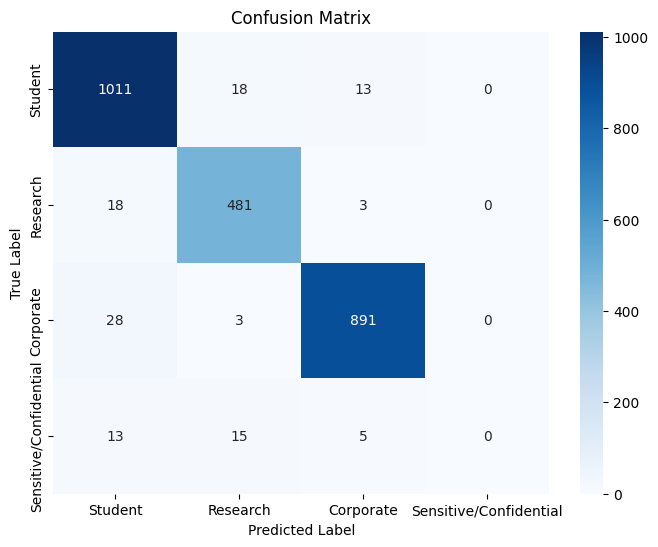

In [32]:

# Visualizing the Confusion Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Student', 'Research', 'Corporate', 'Sensitive/Confidential'],
            yticklabels=['Student', 'Research', 'Corporate', 'Sensitive/Confidential'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()